In [2]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


In [3]:
tf.enable_eager_execution()


In [4]:
# So for a model thats roughly just starting out... what do its logits look like...
detail = {
 'model_loc': 'history/2019-12-29T000509Z/epoch_000_batch_00030_model.h5', 
    'test_loc': 'history/2019-12-22T174803Z/test_balanced.h5', 
 'batch_size': '32', 
 #'work_dir': 'history/2020-01-04T1945Z'
}


In [ ]:
# Borrowing from earlier notebook...
# https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-01-loglossbook--update.md

def get_raw_preds(model, dataloc, dataset_names):
    # dataloc contains the test data..
    lossvec = []
    predsvec = []
    for Xdataset, Ydataset in tqdm(dataset_names):

        X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset) 
        parts = mu.get_partitions(range(X.shape[0]), 100)
        batchlosses = []
        for part in parts:
            preds = model(X[part].astype('float32'))
            loss = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds.numpy()).numpy()
            batchlosses.append(loss)
            predsvec.extend(preds)

        lossvec.append(np.mean(batchlosses))
    return lossvec, predsvec

def plot_logits(vec, title=''):
    plt.plot([x[0] for x in vec], color='blue', label='0')
    plt.plot([x[1] for x in vec], color='green', label='1')
    plt.plot([x[2] for x in vec], color='red', label='2')
    plt.plot([x[3] for x in vec], color='orange', label='3')
    plt.title(title)
    plt.legend()
    
# modelloc = f'history/2019-12-08T220612Z/{modeln}'
model = mu.load_model(detail['model_loc'])

lossvec, predsvec = get_raw_preds(
                    model=model,
                    dataloc=detail['test_loc'],
                    dataset_names=[['X_0', 'Ylabels_0'],
                                  ])
predarr = np.vstack([x.numpy() for x in predsvec])

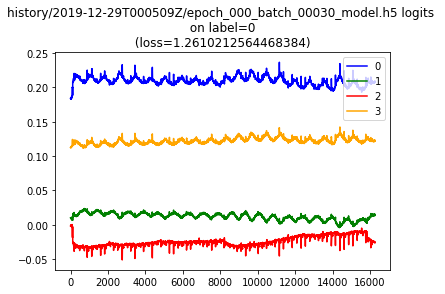

In [11]:
plot_logits(predarr, f'{detail["model_loc"]} logits \n on label=0 \n (loss={lossvec[0]}) ')

In [12]:
%%time
label_logits_vec = {}

for label in tqdm(range(4)):
    print(f'label {label}')
    lossvec, predsvec = get_raw_preds(
                        model=model,
                        dataloc=detail['test_loc'],
                        dataset_names=[[f'X_{label}', f'Ylabels_{label}'],
                                      ])
    predarr = np.vstack([x.numpy() for x in predsvec])
    label_logits_vec[label] = [lossvec, predarr]

  0%|          | 0/1 [00:00<?, ?it/s]

label 0



  0%|          | 0/1 [00:00<?, ?it/s]

label 1



  0%|          | 0/1 [00:00<?, ?it/s]

label 2



  0%|          | 0/1 [00:00<?, ?it/s]

label 3



100%|██████████| 4/4 [02:04<00:00, 31.18s/it]

CPU times: user 2min 3s, sys: 389 ms, total: 2min 4s
Wall time: 2min 4s


using detail["model_loc"]


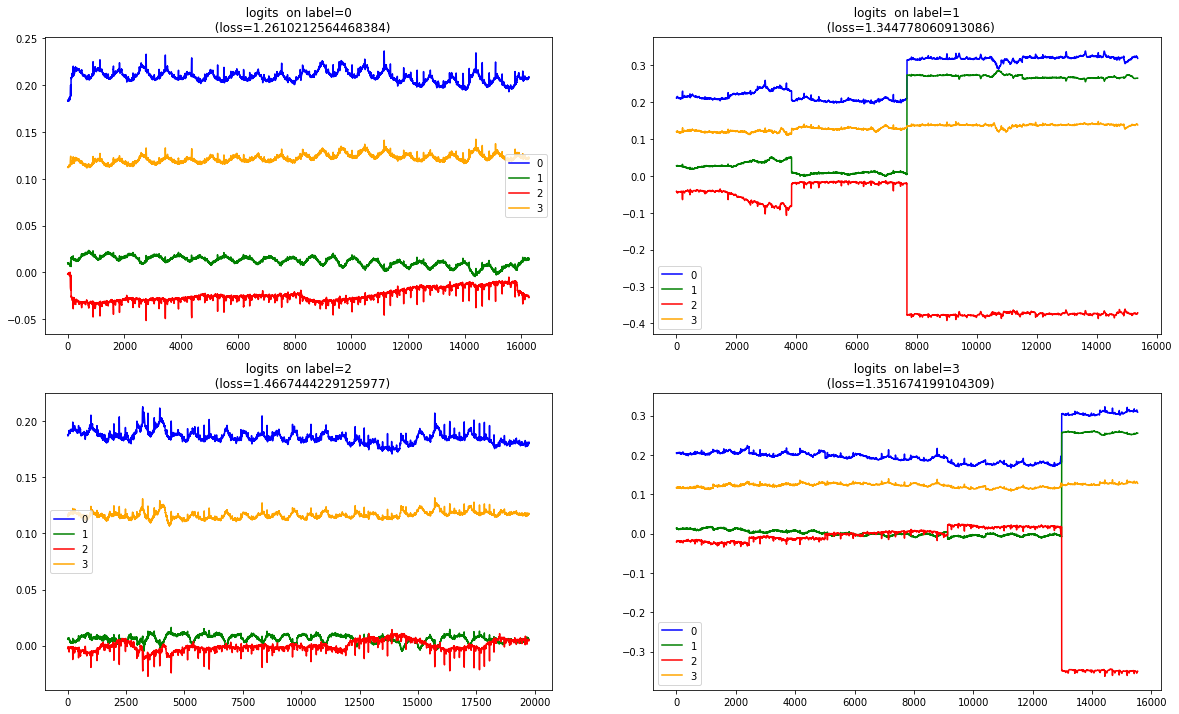

In [21]:

def plot_logits_ax(vec, ax, title=''):
    ax.plot([x[0] for x in vec], color='blue', label='0')
    ax.plot([x[1] for x in vec], color='green', label='1')
    ax.plot([x[2] for x in vec], color='red', label='2')
    ax.plot([x[3] for x in vec], color='orange', label='3')
    ax.set(title=title)
    #ylabel=col,
    #xlabel='time')

    ax.legend()

fig = plt.figure(figsize=(20,12))


for i in range(4):
    ax = fig.add_subplot(int('22' + str(i+1)))
    plot_logits_ax(vec=label_logits_vec[i][1], 
                   ax=ax, 
                   title=(f'  logits '
                          f' on label={i}  \n '
                          f' (loss={label_logits_vec[i][0][0]})'))

                   

print(f'using detail["model_loc"]')


### 2020-01-11

#### what the heck
* These jumps above are gnarly for `label=1` and `label=3` .
* What is it about this validation data jumping?
* Also the logloss hmm , for `label=0` . i feel like it would be way less than `1.0`. 

In [26]:
# Lets review this logloss calc more precisely...
import ipdb
label = 0
lossvec, predsvec =  ipdb.runcall(get_raw_preds,
                        model=model,
                        dataloc=detail['test_loc'],
                        dataset_names=[[f'X_{label}', f'Ylabels_{label}'],
                                      ])


> <ipython-input-5-7bbcc0674959>(6)get_raw_preds()
      5     # dataloc contains the test data..
----> 6     lossvec = []
      7     predsvec = []

ipdb> n
> <ipython-input-5-7bbcc0674959>(7)get_raw_preds()
      6     lossvec = []
----> 7     predsvec = []
      8     for Xdataset, Ydataset in tqdm(dataset_names):

ipdb> 
> <ipython-input-5-7bbcc0674959>(8)get_raw_preds()
      7     predsvec = []
----> 8     for Xdataset, Ydataset in tqdm(dataset_names):
      9 

ipdb> 


  0%|          | 0/1 [00:00<?, ?it/s]

> <ipython-input-5-7bbcc0674959>(10)get_raw_preds()
      9 
---> 10         X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset)
     11         parts = mu.get_partitions(range(X.shape[0]), 100)

ipdb> p Xdataset, Ydataset
('X_0', 'Ylabels_0')
ipdb> n
> <ipython-input-5-7bbcc0674959>(11)get_raw_preds()
     10         X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset)
---> 11         parts = mu.get_partitions(range(X.shape[0]), 100)
     12         batchlosses = []

ipdb> 
> <ipython-input-5-7bbcc0674959>(12)get_raw_preds()
     11         parts = mu.get_partitions(range(X.shape[0]), 100)
---> 12         batchlosses = []
     13         for part in parts:

ipdb> 
> <ipython-input-5-7bbcc0674959>(13)get_raw_preds()
     12         batchlosses = []
---> 13         for part in parts:
     14             preds = model(X[part].astype('float32'))

ipdb> 
> <ipython-input-5-7bbcc0674959>(14)get_raw_preds()
     13         for part in parts:
---> 14             preds = model(X[part]

ipdb> p tf.losses.sparse_softmax_cross_entropy(                          labels=Ylabels[part].astype('int64'),                          logits=preds.numpy()).numpy()
1.2797719
ipdb> p part
range(0, 100)
ipdb> p len(parts)
163
ipdb> p parts[0]
range(0, 100)
ipdb> p parts[2]
range(200, 300)
ipdb> p list(parts[2])[:5]
[200, 201, 202, 203, 204]
ipdb> Ylabels[part].astype('int64')
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
ipdb> p Counter
<class 'collections.Counter'>
ipdb> p Ylabels.shape
(16263,)
ipdb> p Counter(Ylabels)
Counter({0.0: 16263})
ipdb> q


TypeError: 'NoneType' object is not iterable

In [36]:
# print(lossvec)
# [1.2610213]
# ipdb> p X.shape
# (16263, 64, 8)
preds = np.array([[ 1.83809385e-01,  1.00108096e-02, -1.75332371e-03,
         1.12673618e-01],
       [ 1.83426142e-01,  9.55305714e-03, -1.38717750e-03,
         1.12821095e-01],
       [ 1.83396950e-01,  9.47616715e-03, -1.38786808e-03,
         1.12689503e-01],])

for preds, ylabels in [[np.array([[0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],]), np.array([0, 0, 0, 0, 0])],
                      [np.array([[1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],
                                 [1, 0, 0, 0],]), np.array([0, 0, 0, 0, 0])],
                      [np.array([[1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],
                                 [1, 0, 0, 1],]), np.array([0, 0, 0, 0, 0])],
                      [np.array([[2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],
                                 [2, 0, 0, 0],]), np.array([0, 0, 0, 0, 0])],
                      [np.array([[9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],
                                 [9, 0, 0, 0],]), np.array([0, 0, 0, 0, 0])],
                      [np.array([[ 1.83809385e-01,  1.00108096e-02, -1.75332371e-03,
                         1.12673618e-01],
                       [ 1.83426142e-01,  9.55305714e-03, -1.38717750e-03,
                         1.12821095e-01],
                       [ 1.83396950e-01,  9.47616715e-03, -1.38786808e-03,
                         1.12689503e-01],]), np.array([0, 0, 0])],

                       
                      ]:
    loss = tf.losses.sparse_softmax_cross_entropy(
                         labels=ylabels.astype('int64'),
                         logits=preds.astype('float64')).numpy()
    print({'ylabels': ylabels, 'preds': preds, 'loss': loss})


{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]]), 'loss': 1.3862943649291992}
{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]]), 'loss': 0.7436683773994446}
{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 1]]), 'loss': 1.0064088106155396}
{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0]]), 'loss': 0.3407529592514038}
{'ylabels': array([0, 0, 0, 0, 0]), 'preds': array([[9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0],
       [9, 0, 0, 0]]), 'loss': 0.00037016088026575744}
{'ylabels': array([0, 0, 0]), 'preds': array([[ 0.18380938,  0.01001081, -0.00175332,  0.1126736

In [ ]:
# So looking at the above, the tf.losses.sparse_softmax_cross_entropy appears to want,
# Not a softmax kind of output where each logit adds to 1.0. 
# Since that clearly yields around 0.74
#
# Instead a high [9, 0, 0, 0] here produces a nice low logloss like 0.000 
#
# But definitely nice to see that [1, 0, 0, 1] logloss is more than that for [1, 0, 0, 0]
# meaning it definitely penalizes the wrong logits. So thats good.

In [40]:
# Ok ... lookat the flattened data again... 
# So for label=1 , after dataset 7500, 
X, Ylabels = mu.read_h5_two(source_location=detail['test_loc'], 
                            Xdataset='X_1', 
                            Ydataset='Ylabels_1') 


In [46]:
#X[:, :, 0].ravel().shape
# (983744,)

X.shape


(15371, 64, 8)

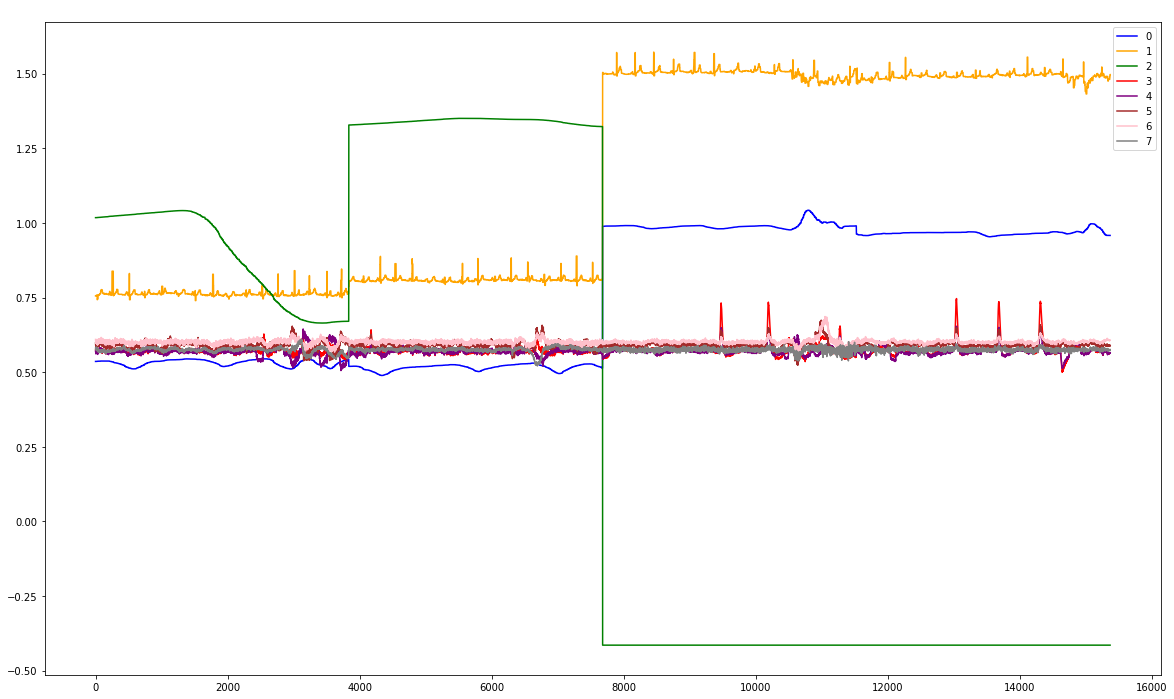

In [50]:
fig = plt.figure(figsize=(20,12))
colors = [
    'blue', 'orange', 
    'green', 'red', 'purple', 
    'brown', 'pink', 'gray', 'olive', 'cyan']
ax = fig.add_subplot(int('111'))
for j in range(8):
    ax.plot(X[:, 0, j].ravel(), color=colors[j], label=f'{j}')
    ax.set(title='test data , label=1')
    #ylabel=col,
    #xlabel='time'

    ax.legend()




In [47]:
# I guess from looking at the above, this may be related to the fact that the
# MinMax Scaler I used for training data has some data that , 
# does not bound the test data. 
# 
# So what does one do about that? Should the test data be clipped ? Hmm
# Or maybe the minMaxScaler should be built from more data.
# So basically I can take another stap perhaps on 
# this , https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21--update.md


983744


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

label 0




100%|██████████| 1/1 [00:18<00:00, 18.56s/it]

 25%|██▌       | 1/4 [00:18<00:56, 18.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 1




100%|██████████| 1/1 [00:13<00:00, 13.59s/it]

 50%|█████     | 2/4 [00:32<00:34, 17.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 2




100%|██████████| 1/1 [00:15<00:00, 15.49s/it]

 75%|███████▌  | 3/4 [00:48<00:16, 16.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 3




100%|██████████| 1/1 [00:16<00:00, 16.14s/it]

100%|██████████| 4/4 [01:04<00:00, 16.08s/it]


CPU times: user 1min 3s, sys: 248 ms, total: 1min 4s
Wall time: 1min 4s


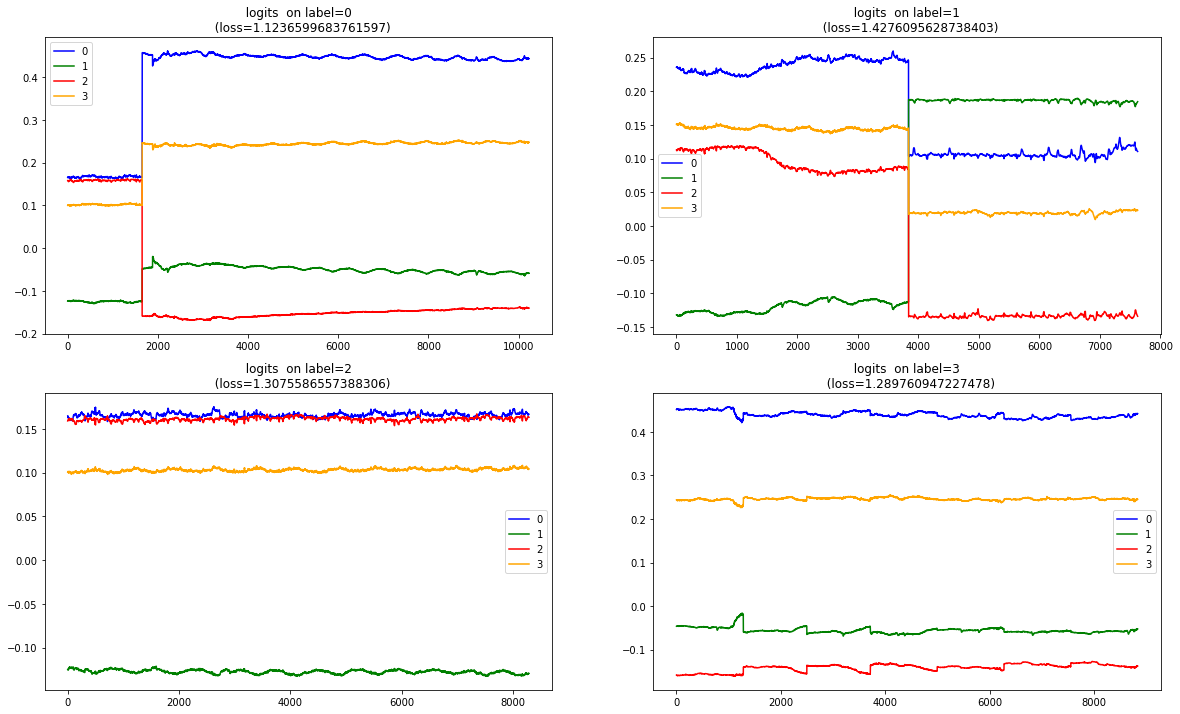

In [52]:
%%time
# ok... and just one more time, look at train data again..
moredetail = {'train_loc': 'history/2019-12-22T174803Z/train_balanced.h5', }

label_logits_vec = {}

for label in tqdm(range(4)):
    print(f'label {label}')
    lossvec, predsvec = get_raw_preds(
                        model=model,
                        dataloc=moredetail['train_loc'],
                        dataset_names=[[f'X_{label}', f'Ylabels_{label}'],
                                      ])
    predarr = np.vstack([x.numpy() for x in predsvec])
    label_logits_vec[label] = [lossvec, predarr]
    
fig = plt.figure(figsize=(20,12))


for i in range(4):
    ax = fig.add_subplot(int('22' + str(i+1)))
    plot_logits_ax(vec=label_logits_vec[i][1], 
                   ax=ax, 
                   title=(f'  logits '
                          f' on label={i}  \n '
                          f' (loss={label_logits_vec[i][0][0]})'))

                   



In [ ]:
# Hmm, dang so eventhough this is training data ^^ umm, which yes it has been all 
# nicely scaled into -1.0, 1.0, 
# it is still showing these crazy jumps. But I thought I shuffled this data niecly. Hmm.
# I mean it should be ok to have different kind of data. But yea I thought I had shuffled it.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

label 0




100%|██████████| 1/1 [00:18<00:00, 18.62s/it]

 25%|██▌       | 1/4 [00:18<00:56, 18.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 1




100%|██████████| 1/1 [00:13<00:00, 13.63s/it]

 50%|█████     | 2/4 [00:32<00:34, 17.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 2




100%|██████████| 1/1 [00:14<00:00, 14.96s/it]

 75%|███████▌  | 3/4 [00:47<00:16, 16.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

label 3




100%|██████████| 1/1 [00:16<00:00, 16.60s/it]

100%|██████████| 4/4 [01:04<00:00, 16.08s/it]


CPU times: user 1min 4s, sys: 275 ms, total: 1min 5s
Wall time: 1min 4s


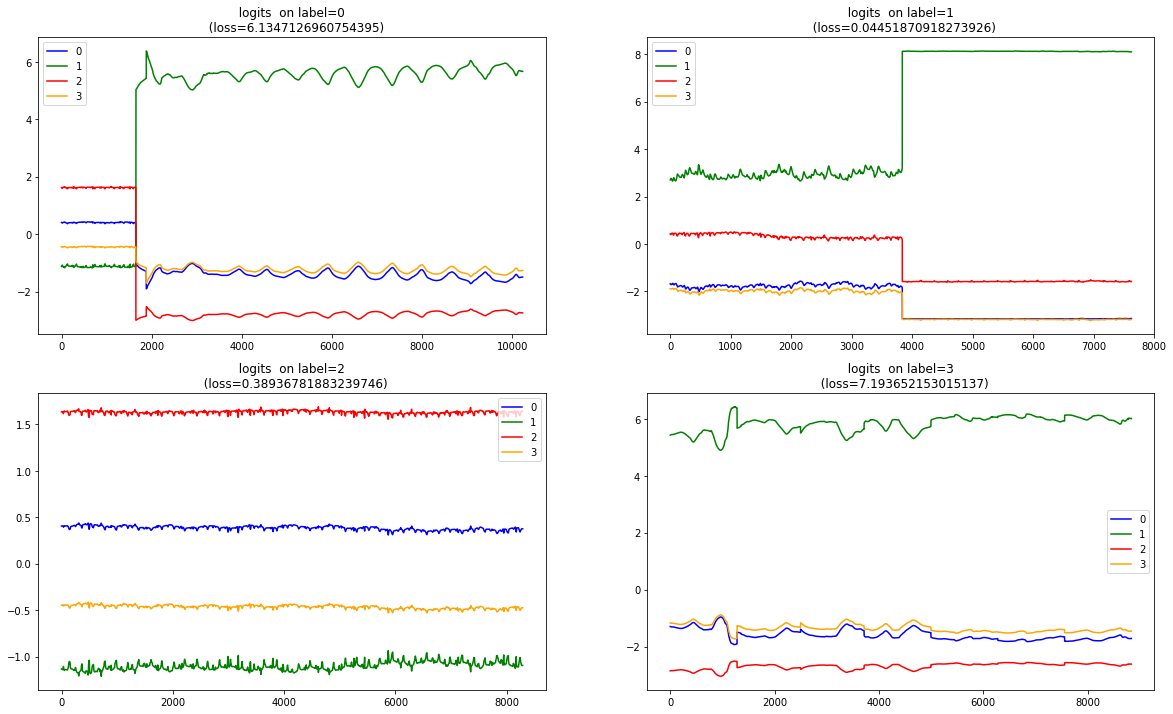

In [54]:
%%time
# and ... on a model after many batches...
modelloc = 'history/2019-12-29T000509Z/epoch_002_batch_01090_model.h5'
model = mu.load_model(modelloc)


# ok... and just one more time, look at train data again..
moredetail = {'train_loc': 'history/2019-12-22T174803Z/train_balanced.h5', }

label_logits_vec = {}

for label in tqdm(range(4)):
    print(f'label {label}')
    lossvec, predsvec = get_raw_preds(
                        model=model,
                        dataloc=moredetail['train_loc'],
                        dataset_names=[[f'X_{label}', f'Ylabels_{label}'],
                                      ])
    predarr = np.vstack([x.numpy() for x in predsvec])
    label_logits_vec[label] = [lossvec, predarr]
    
fig = plt.figure(figsize=(20,12))


for i in range(4):
    ax = fig.add_subplot(int('22' + str(i+1)))
    plot_logits_ax(vec=label_logits_vec[i][1], 
                   ax=ax, 
                   title=(f'  logits '
                          f' on label={i}  \n '
                          f' (loss={label_logits_vec[i][0][0]})'))

                   


In [ ]:
# hmm ok and the above is looking at the model 
# `history/2019-12-29T000509Z/epoch_002_batch_01090_model.h5` , 
# which although the train log loss, 
# seen here https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-28-two-plot.md 
# is getting better, it is the loss of the batches and ok looking above, 
# The full training set logloss only looks good for 2 out of 4 of the labels.
